# OCR example with removing background noise

## Install spark-ocr python packge
Need specify path to `spark-ocr-assembly-[version].jar` or `secret`

In [47]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [ ]:
import sys
import os

if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version+spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

In [ ]:
# or install from local path
# %pip install ../../python/dist/spark-ocr-[version].tar.gz

## Initialization of spark session

In [49]:
from pyspark.sql import SparkSession
from sparkocr import start

if license:
    os.environ['JSL_OCR_LICENSE'] = license

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

SparkConf Configured, Starting to listen on port: 62957
JAR PATH:/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar


## Imports

In [50]:
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image
from sparkocr.metrics import score

## Define OCR transformers

In [51]:
# Read binary as image
binary_to_image = BinaryToImage()
binary_to_image.setInputCol("content")
binary_to_image.setOutputCol("image")

# Scale image
scaler = ImageScaler()
scaler.setInputCol("image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2.0)

# Binarize using adaptive tresholding
binarizer = ImageAdaptiveThresholding()
binarizer.setInputCol("scaled_image")
binarizer.setOutputCol("binarized_image")
binarizer.setBlockSize(91)
binarizer.setOffset(60)
binarizer.setKeepInput(True)

# Apply morphology opening
opening = ImageMorphologyOperation()
opening.setKernelShape(KernelShape.SQUARE)
opening.setOperation(MorphologyOperationType.OPENING)
opening.setKernelSize(2)
opening.setInputCol("binarized_image")
opening.setOutputCol("opening_image")
opening.setKeepInput(True)

# Remove small objects
remove_objects = ImageRemoveObjects()
remove_objects.setInputCol("opening_image")
remove_objects.setOutputCol("corrected_image")
remove_objects.setMinSizeFont(30)
remove_objects.setKeepInput(True)

# Run OCR for each region
ocr = ImageToText()
ocr.setInputCol("corrected_image")
ocr.setOutputCol("text")
ocr.setConfidenceThreshold(75)
ocr.setPageSegMode(PageSegmentationMode.SINGLE_BLOCK)
ocr.setIgnoreResolution(False)


# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    scaler,
    binarizer,
    opening,
    remove_objects,
    ocr
])

## Read image with noised background

In [52]:
import pkg_resources
imagePath = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/noised.png')
image_df = spark.read.format("binaryFile").load(imagePath).cache()
image_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/Users/nmeln...|2020-03-09 15:29:58|430295|[89 50 4E 47 0D 0...|
+--------------------+-------------------+------+--------------------+



## Run OCR pipelines

In [53]:
result = pipeline \
.transform(image_df).cache()

## Results

In [54]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|*Sur la base de l...|89.37251281738281|
+--------------------+-----------------+



### Display detected min font size

In [55]:
positions = result.select("positions").head().positions
mappings = [ mapping.fontSize for pos in positions for mapping in pos.mapping ]
print(min(mappings))

35


### Display text

In [56]:
print("\n".join([row.text for row in result.select("text").collect()]))

*Sur la base de la grande statue de Zeus, 4 Olympie, Phidias avait
représenté les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Séléné)
les douze divinités, groupées deux a deux, s’ordonnaient en six couples :
un dieu-une déesse. Au centre de 1a frise, en surnombre, les deux divini-
tés: (féminine et masculine) qui président aux unions: Aphrodite et
Eros”, Dans cette série de huit couples divins, il en est un qui fait pro-
bléme : Hermés-Hestia. Pourquoi les apparier ? Rien dans leur généalo-
gie ni dans leur légende qui puisse justifier cette association. Ils ne sont
pas mari et femme (comme Zeus-Héra, Poséidon-Amphitrite, Héphaistos-
Charis), ni frére et sccur (comme Apollon-Artémis, Hélios-Séléné), ni
mére et fils (comme Aphrodite-Eros), ni protectrice et protégé (comme
Athéna-Héraclés). Quel lien unissait donc, dans l’esprit de Phidias, un
dieu et une déesse qui semblent étrangers l’un a l’autre ? On ne saurait
alléguer une fantaisie personnelle du sculpteur. Quand il exécute u

## Display image for each stage

Original: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png 
        width: 1312
        height: 948
        mode: 10


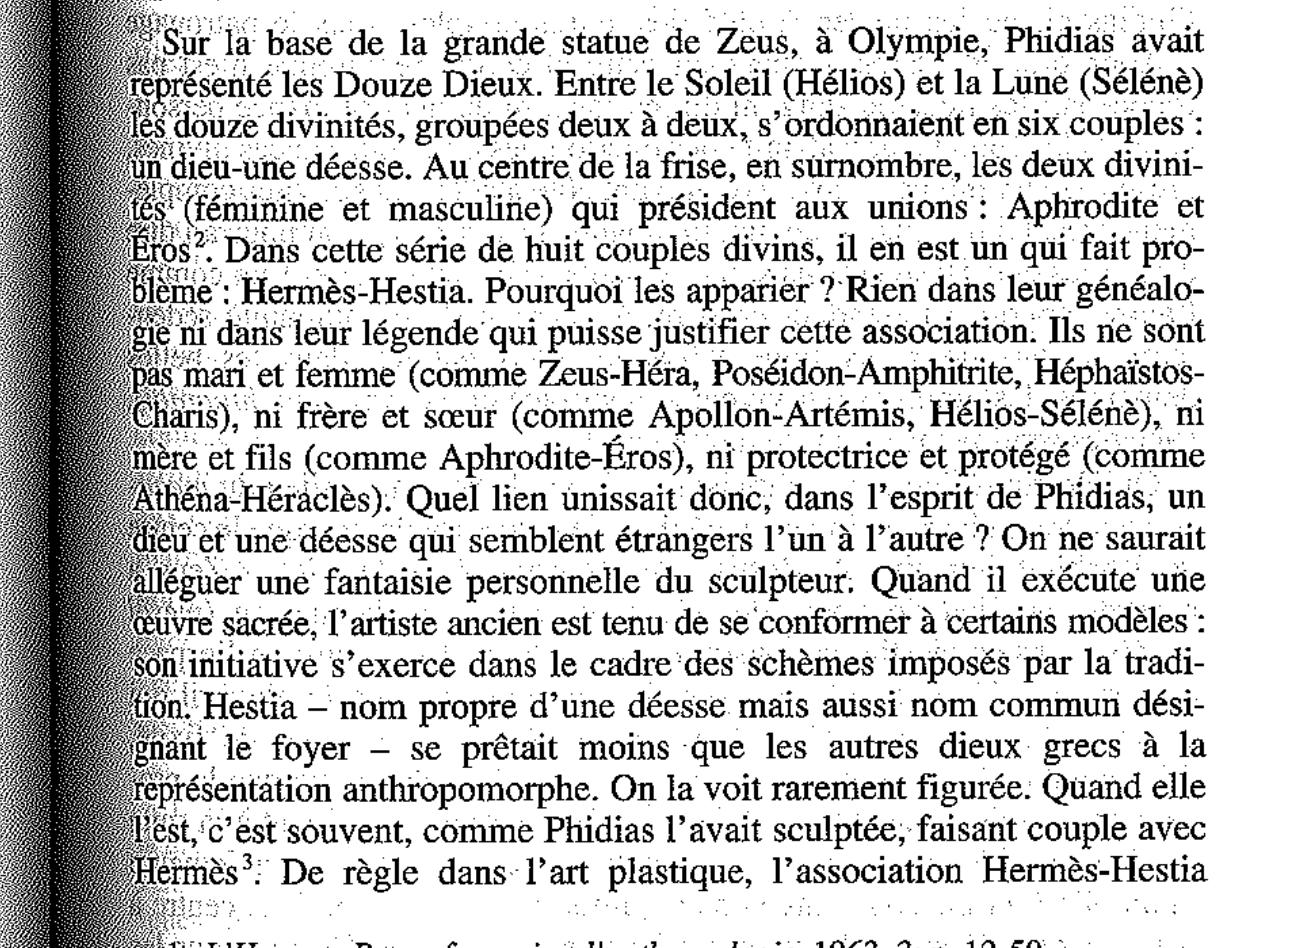

Binarized: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png 
        width: 2624
        height: 1896
        mode: 10


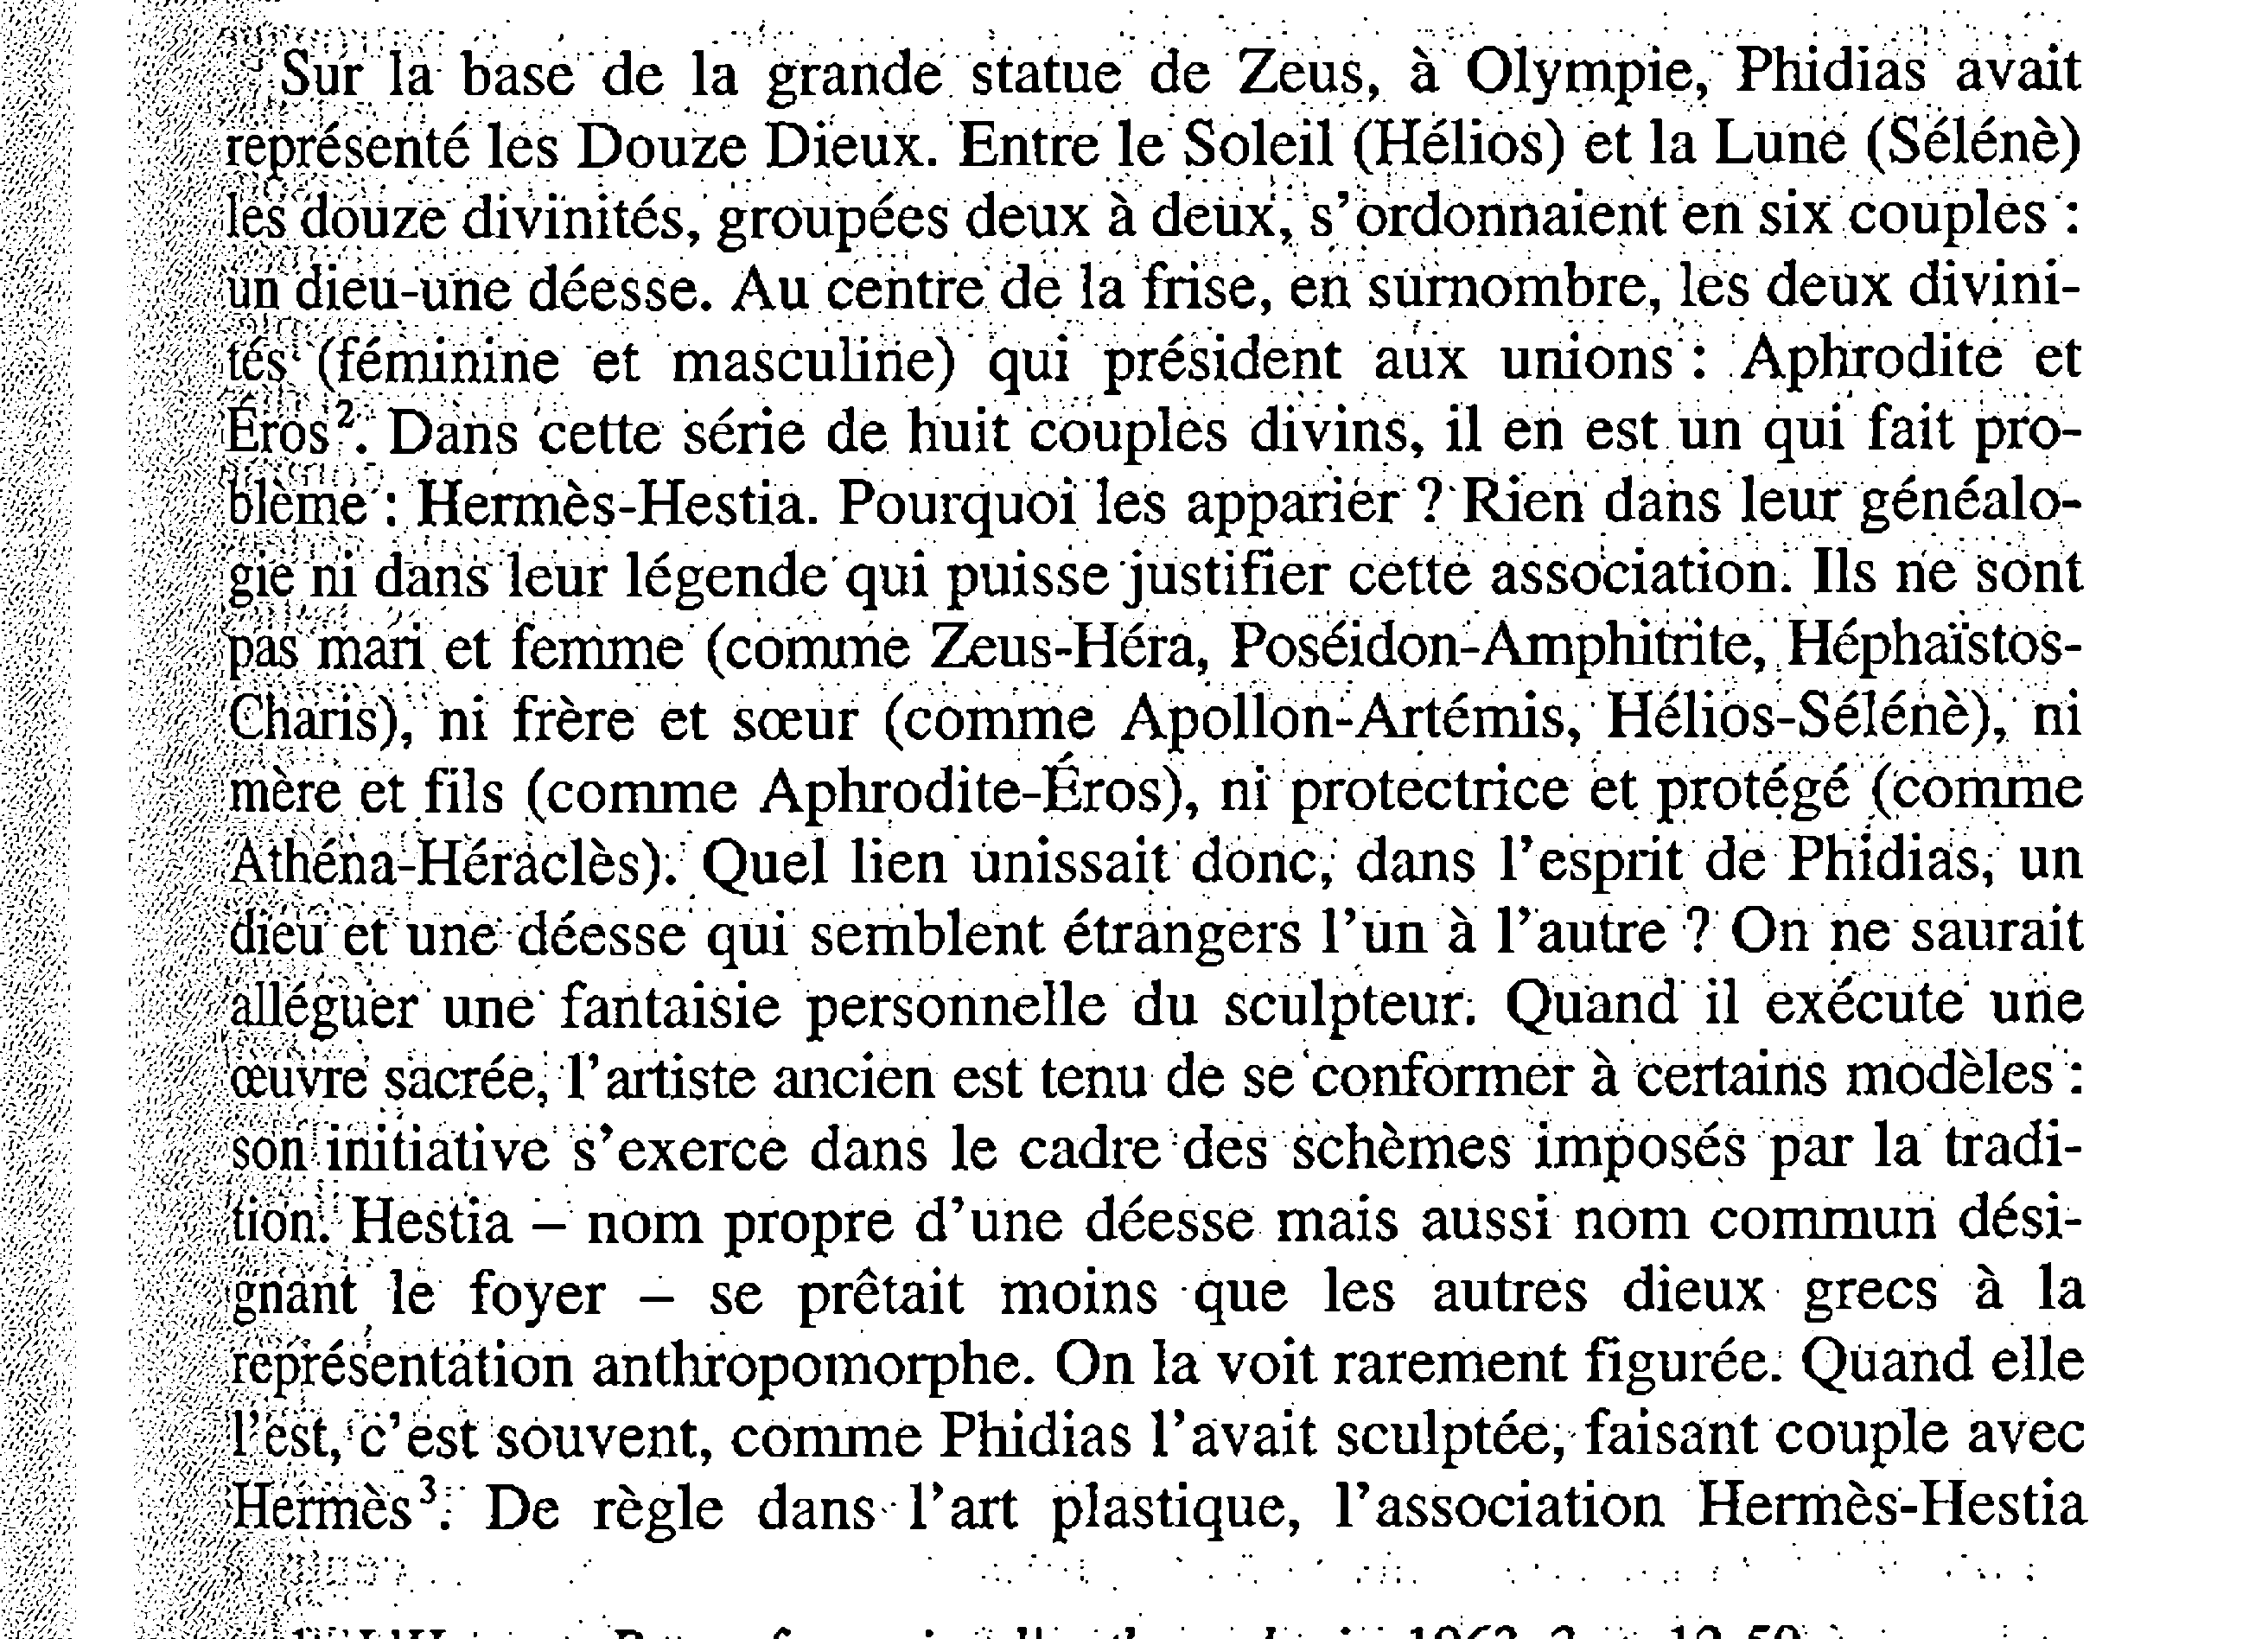

Morphology opening: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png 
        width: 2624
        height: 1896
        mode: 10


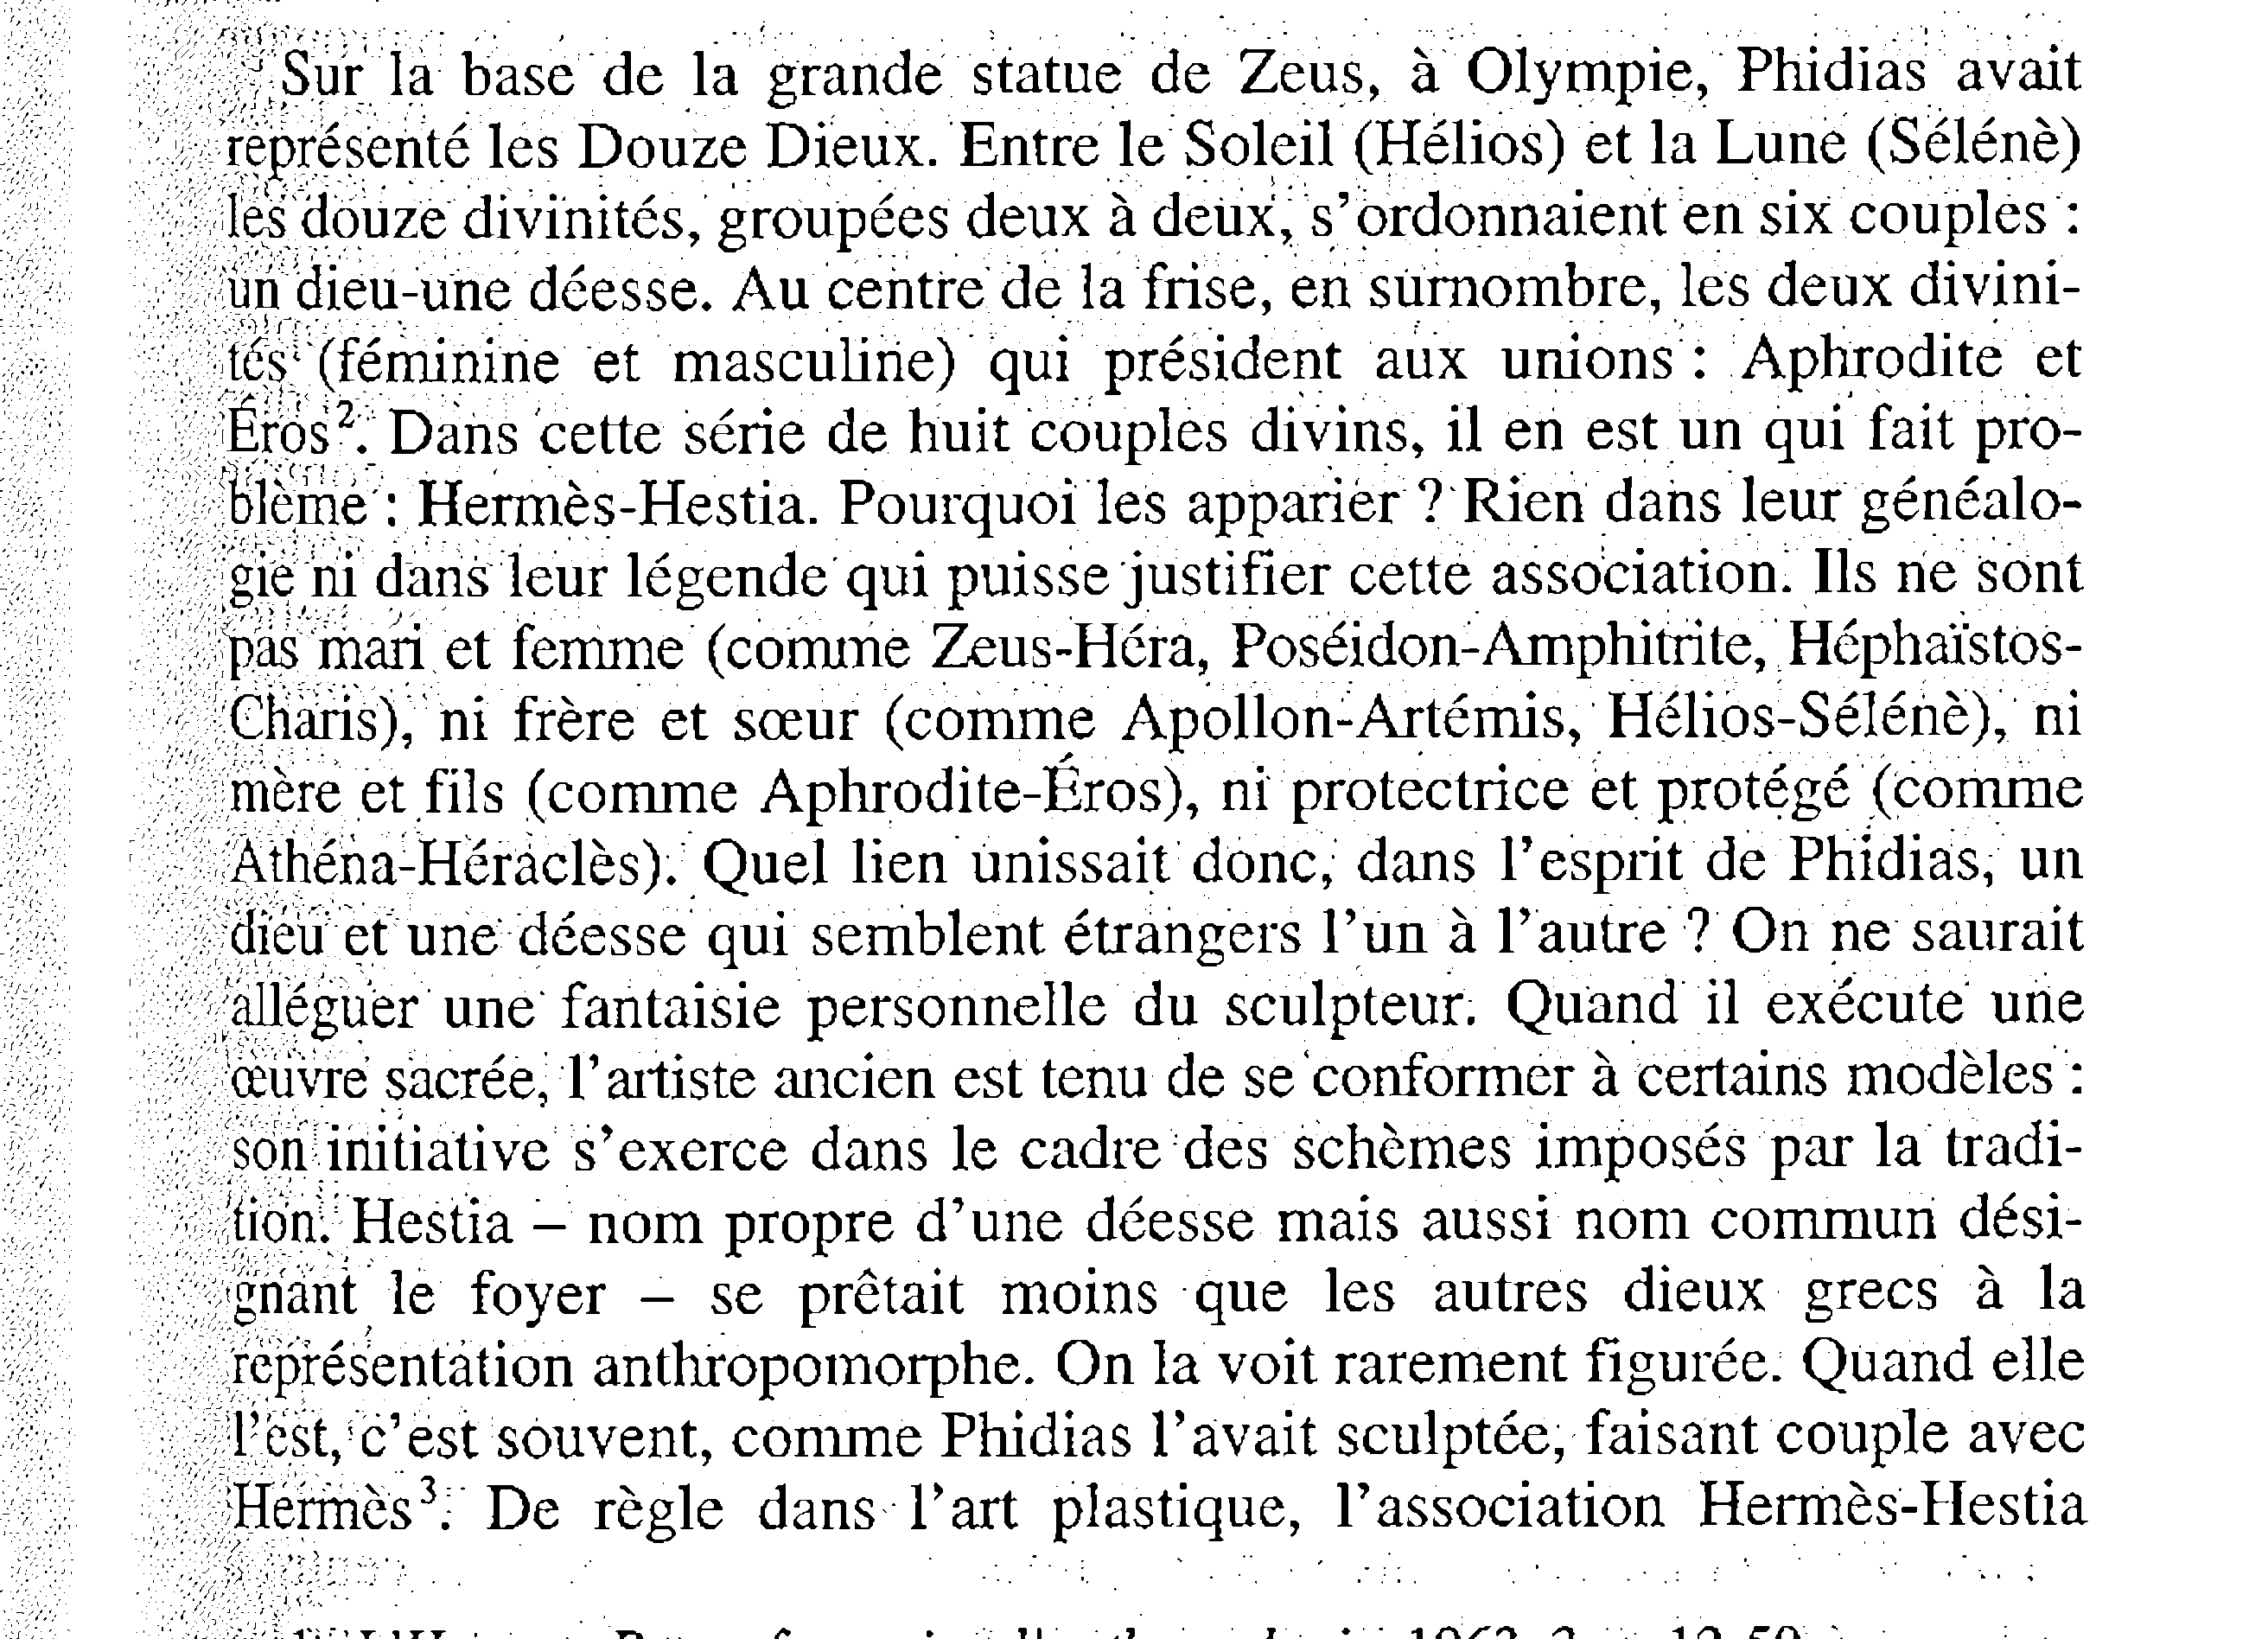

Remove small objects: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png
Image:
        origin: file:/Users/nmelnik/Library/Python/3.7/lib/python/site-packages/sparkocr/resources/ocr/images/noised.png 
        width: 2624
        height: 1896
        mode: 10


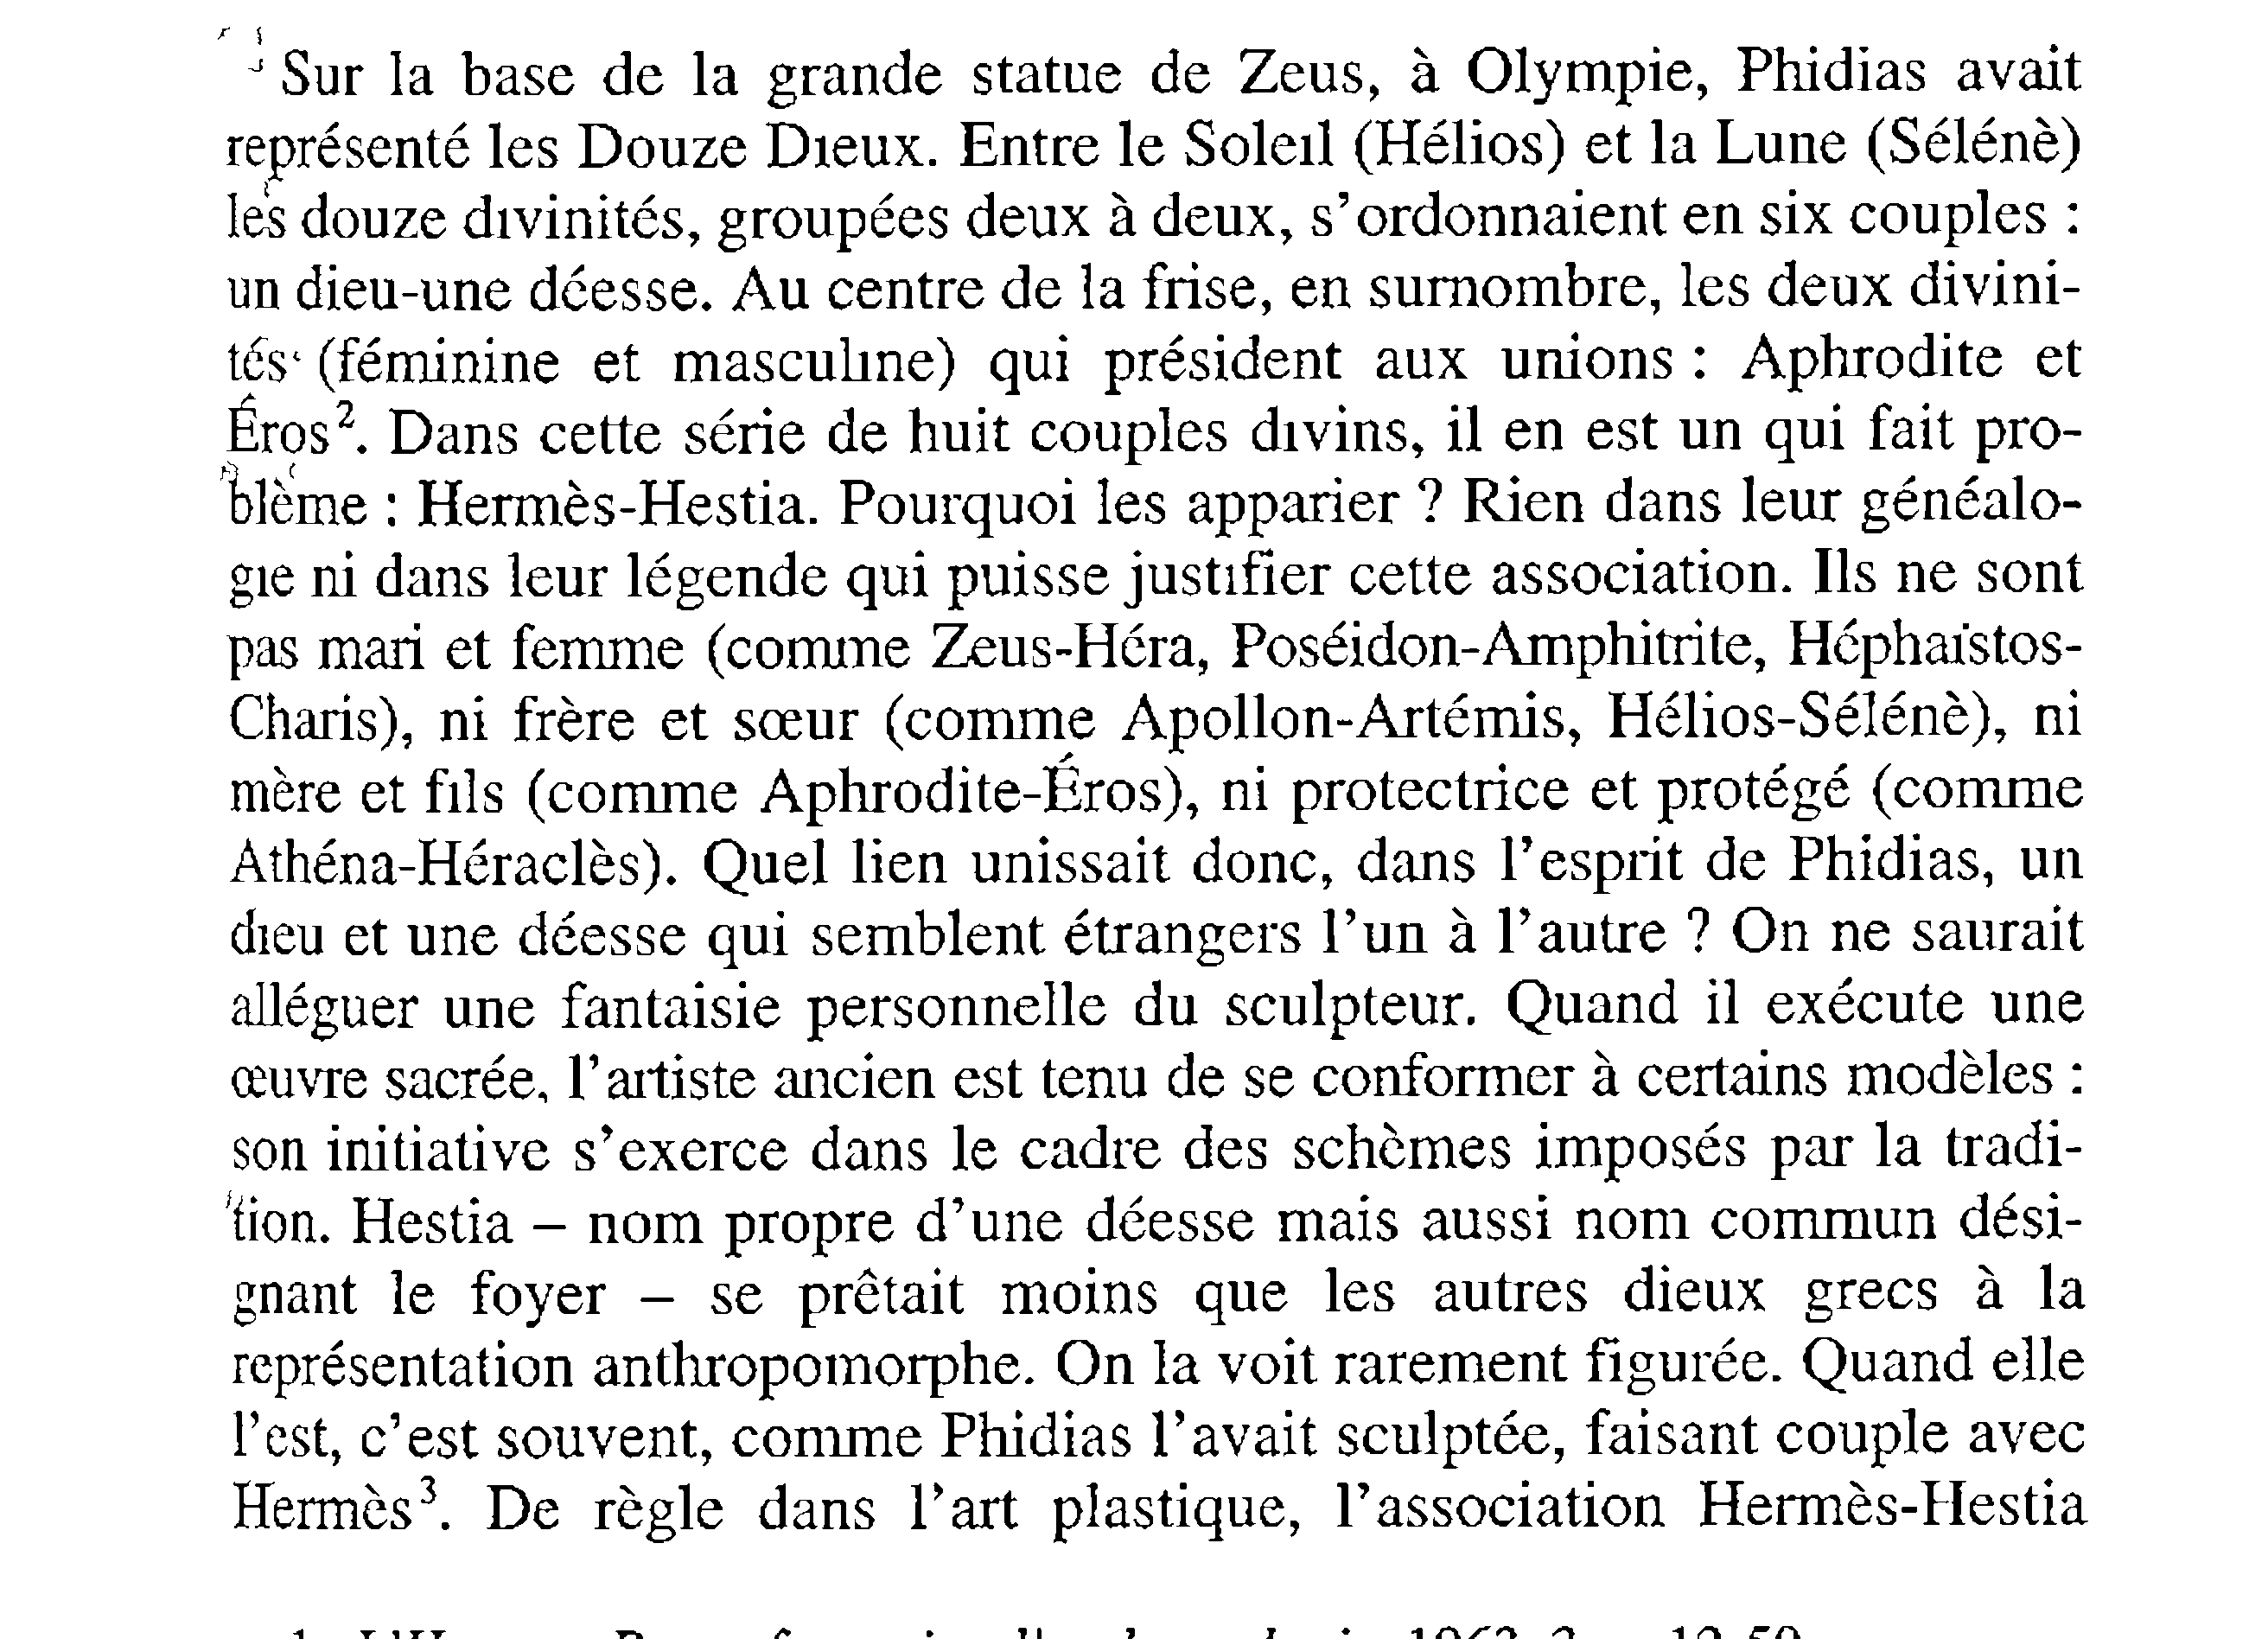

In [57]:
for r in result.distinct().collect():
    print("Original: %s" % r.path)
    display_image(r.image)
    print("Binarized: %s" % r.path)
    display_image(r.binarized_image)
    print("Morphology opening: %s" % r.path)
    display_image(r.opening_image)
    print("Remove small objects: %s" % r.path)
    display_image(r.corrected_image)

## Compute score and compare it with ABBYY FineReader and AWS TextRact results

In [58]:
# text recognized by ABBYY FineReader
abbyy_finereader = """Sur la base de la grande statue de Zeus, à Olympie, Phidias avait
présenté les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Sëlénè)
& douze divinités, groupées deux à deux, s’ordonnaient en six couples :
n dieu-une déesse. Au centre de la frise, en surnombre, les deux divini-
(féminine et masculine) qui président aux unions : Aphrodite et
ms2;; Dans cette série de huit couples divins, il en est un qui fait prolemé : Hermès-Hestia. Pourquoi les apparier ? Rien dans leur généaloJfêfriï dans leur légende qui puisse justifier cette association: Ils rie sont
M m ari et femme (comme Zeus-Héra, Poséidon-Amphitrite, HéphaïstosÊHaris), ni frère et sœur (comme Apollon-Artémis, Hélios-Sélériè), ni
mère et fils (comme Aphrodite-Eros), ni protectrice et protégé (comme
théna Héraclès). Quel lien unissait donc, dans T esprit de Phidias, un
lieu et une dée s s e qui semblent étrangers l’un à l’autre ? On ne saurait
‘"eguer une fantaisie personnelle du sculpteur. Quand il exécuté une
livre sacrée, T artiste ancien est tenu de se conformer à certains modèles :
|®ihitiative s’exerce dans le cadre des schèmes imposes par la tradiipnV Hestia - nom propre d’une déesse mais aussi nom commun désignant le foyer - se prêtait moins que les autres dieux grecs à la
èprésentation anthropomorphe. On la voit rarement figurée. Quand elle
’est,5c’est souvent, comme Phidias l’avait sculptée, faisant couple avec
érmës3. De règle dans l’art plastique, l’association Hermès-Hestia
RpvÆ îi. -4'i 1 T l T i A r o a -i a """

# text recognized by AWS TextRact
text_ract = """Sur la base de la grande statue de Zeus, a Olympie, Phidias avait
represente les Douze Dieux. Entre le Soleil (Helios) et la Lune (Selene)
les douze divinites, groupees deux a deuix, s ordonnaient en six couples :
un dieu-une deesse. Au centre de la frise, en surnombre, les deux divini-
tes (feminine et masculine) que president aux unions : Aphrodite et
Eros?. Dans cette serie de huit couples divins, il en est un qui fait pro-
bleme': Hermes-Hestia. Pourquoi les apparier ? Rien dans leur genealo-
gre nI dans leur legende qui puisse justifier cette association. Ils ne sont
pas mari et femme (comme Zeus-Hera, Poseidon-Amphitrite, Hephaistos-
Charis), ni frere et soeur (comme Apollon-Artemis, Helios-Selene), ni
mere et fils (comme Aphrodite-Eros), ni protectrice et protege (comme
Athena-Heracles): Quel lien unissait donc, dans l'esprit de Phidias; un
dieu et une deesse qui semblent etrangers 'un a 1'autre ? On ne saurait
alleguer une fantaisie personnelle du sculpteur: Quand il execute une
ceuvre sacree, T'artiste ancien est tenu de se conformer a certains modeles :
son initiative 'exerce dans le cadre des schemes imposes par la tradi-
tion. Hestia - nom propre d'une deesse mais aussi nom commun desi-
gnant le foyer - se pretait moins que les autres dieux grecs a la
representation anthropomorphe. On la voit rarement figuree. Quand elle
Pest, c est souvent, comme Phidias 'avait sculptee, faisant couple avec
Hermes3 De regle dans l'art plastique, I'association Hermes-Hestia
TYy,,"""

In [59]:
detected = "\n".join([row.text for row in result.collect()])

# Read original text
origin_text_file = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/noised.txt')
origin_text = open(origin_text_file, "r").read()

# Compute scores
abbyy_score = score(origin_text, abbyy_finereader)
textract_score = score(origin_text, text_ract)
corrected_score = score(origin_text, detected)

print("Abbyy FineReader score: {0}".format(abbyy_score))
print("Text Ract score: {0}".format(textract_score))
print("Score Spark NLP: {0}".format(corrected_score))

Abbyy FineReader score: 0.8972648432288192
Text Ract score: 0.9323962516733602
Score Spark NLP: 0.9812583668005356


## Original text

In [60]:
print(origin_text)

Sur la base de la grande statue de Zeus, a Olympie, Phidias avait
représenté les Douze Dieux. Entre le Soleil (Hélios) et la Lune (Séléné)
les douze divinités, groupées deux a deux, s’ordonnaient en six couples :
un dieu-une déesse. Au centre de la frise, en surnombre, les deux divini-
tés (féminie et masculine) qui président aux unions: Aphrodite et
Éros. Dans cette série de huit couples divins, il en est un qui fait pro-
bléme : Hermés-Hestia. Pourquoi les apparier ? Rien dans leur généalo-
gie ni dans leur légende qui puisse justifier cette association. Ils ne sont
pas mari et femme (comme Zeus-Héra, Poséidon-Amphitrite, Héphaistos-
Charis), ni frére et sœur (comme Apollon-Artémis, Hélios-Séléné), ni
mére et fils (comme Aphrodite-Eros), ni protectrice et protégé (comme
Athéna-Héraclés), Quel lien unissait donc, dans l’esprit de Phidias, un
dieu et une déesse qui semblent étrangeis l’un a l’autre ? On ne saurait
alléguer une fantaisie personnelle du sculpteur. Quand il exécute une
œu